In [42]:
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

MODEL_DIR = './models/final/'
MODEL_PATH = os.path.join(MODEL_DIR, 'final_model.pkl')
PREPROCESSOR_PATH = os.path.join(MODEL_DIR, 'preprocessor.pkl')
MAPPING_PATH = './models/result_mapping.npy'

In [43]:
try:
    if not os.path.exists(MODEL_PATH):
        raise FileNotFoundError(f"Model file not found at: {MODEL_PATH}")
    if not os.path.exists(PREPROCESSOR_PATH):
        raise FileNotFoundError(f"Preprocessor file not found at: {PREPROCESSOR_PATH}")
    if not os.path.exists(MAPPING_PATH):
        raise FileNotFoundError(f"Mapping file not found at: {MAPPING_PATH}")
    model = joblib.load(MODEL_PATH)
    preprocessor = joblib.load(PREPROCESSOR_PATH)
    label_mapping = np.load(MAPPING_PATH, allow_pickle=True)
    print("Model loaded successfully.")
    print("Preprocessor loaded successfully.")
    print("Label mapping loaded successfully:", label_mapping)
except Exception as e:
    print(f"Error loading artifacts: {e}")
    raise SystemExit("Could not load necessary artifacts.")

Model loaded successfully.
Preprocessor loaded successfully.
Label mapping loaded successfully: ['Extra-Base Hit' 'Home Run' 'Out' 'Single']


In [44]:
# Pitch Characteristics
pitch_velocity = 94.2
perceived_velocity = 98.1
spin_rate = 2350
vertical_release = 5.9
horizontal_release = -1.8 # Inside to RHB
extension = 6.7
px = -0.3 # Slightly inside
pz = 2.8 # Belt high
arm_angle = 15.0
pitch_type = '4-Seam Fastball'

# Swing Characteristics
bat_speed = 50.1
swing_length = 7.2

In [45]:
inside_pitch = px < 0
high_pitch = pz > 3.2
low_pitch = pz < 2.0

# Handle potential division by zero
if swing_length != 0:
    swing_efficiency_ratio = bat_speed / swing_length
else:
    swing_efficiency_ratio = 0

speed_differential = bat_speed - pitch_velocity

# Pitch Category
fastball_types = ['4-Seam Fastball', '2-Seam Fastball', 'Cutter', 'Sinker', 'Split-Finger', 'Fastball']
breaking_types = ['Slider', 'Sweeper', 'Curveball', 'Knuckle Curve', 'Slurve']
offspeed_types = ['Changeup', 'Forkball', 'Eephus']

if pitch_type in fastball_types:
    pitch_category = 'Fastball'
elif pitch_type in breaking_types:
    pitch_category = 'Breaking'
elif pitch_type in offspeed_types:
    pitch_category = 'Offspeed'
else:
    pitch_category = 'Other'

In [46]:
input_data = {
    # Numerical Features
    'pitch_velocity': pitch_velocity,
    'perceived_velocity': perceived_velocity,
    'spin_rate': spin_rate,
    'vertical_release': vertical_release,
    'horizontal_release': horizontal_release,
    'extension': extension,
    'arm_angle': arm_angle,
    'px': px,
    'pz': pz,
    'bat_speed': bat_speed,
    'swing_length': swing_length,
    'swing_efficiency_ratio': swing_efficiency_ratio,
    'speed_differential': speed_differential,
    'inside_pitch': inside_pitch,
    'high_pitch': high_pitch,
    'low_pitch': low_pitch,

    # Categorical Features (verify order based on preprocessor.transformers_[1][2])
    'pitch_type': pitch_type,
    'pitch_category': pitch_category,
}

# Create DataFrame with a single row
input_df = pd.DataFrame([input_data])
print("Input DataFrame structure:")
print(input_df.info())
print(input_df.head())

Input DataFrame structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   pitch_velocity          1 non-null      float64
 1   perceived_velocity      1 non-null      float64
 2   spin_rate               1 non-null      int64  
 3   vertical_release        1 non-null      float64
 4   horizontal_release      1 non-null      float64
 5   extension               1 non-null      float64
 6   arm_angle               1 non-null      float64
 7   px                      1 non-null      float64
 8   pz                      1 non-null      float64
 9   bat_speed               1 non-null      float64
 10  swing_length            1 non-null      float64
 11  swing_efficiency_ratio  1 non-null      float64
 12  speed_differential      1 non-null      float64
 13  inside_pitch            1 non-null      bool   
 14  high_pitch         

In [47]:
try:
    input_processed = preprocessor.transform(input_df)
    print("Preprocessing successful.")
except Exception as e:
    print(f"Error during preprocessing: {e}")
    raise SystemExit("Preprocessing failed.")

Preprocessing successful.


In [48]:
print("\n--- Predicting Probabilities ---")
try:
    probabilities = model.predict_proba(input_processed)[0]
    print(f"Prediction successful. prob: {probabilities}")
except Exception as e:
    print(f"Error during prediction: {e}")
    raise SystemExit("Prediction failed.")


--- Predicting Probabilities ---
Prediction successful. prob: [0.12590372 0.07920424 0.3533804  0.44151164]


          Outcome Probability (%)
0          Single          44.15%
1             Out          35.34%
2  Extra-Base Hit          12.59%
3        Home Run           7.92%


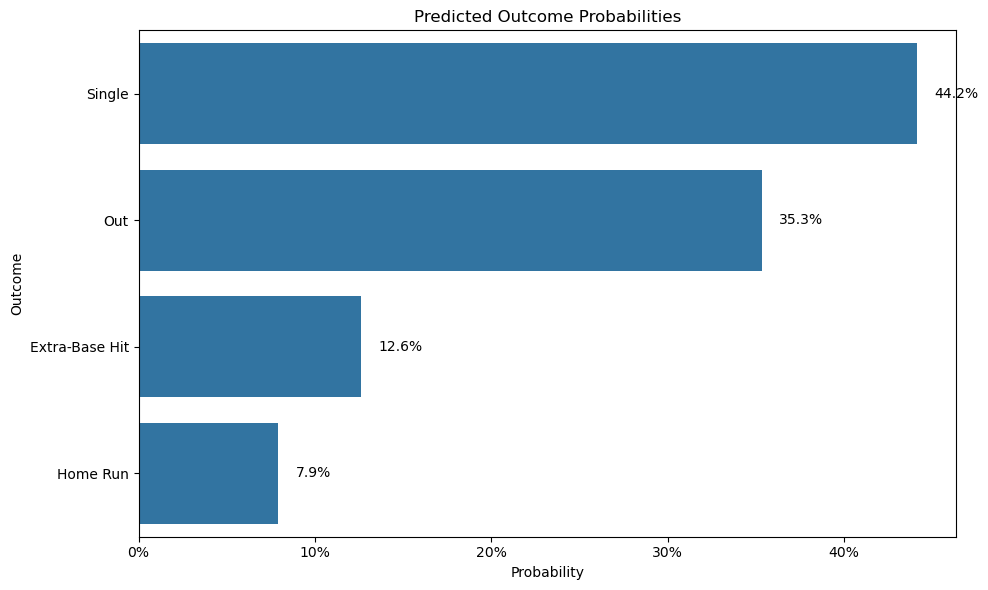

In [ ]:
if len(probabilities) == len(label_mapping):
    results_df = pd.DataFrame({
        'Outcome': label_mapping,
        'Probability': probabilities
    }).sort_values(by='Probability', ascending=False).reset_index(drop=True)
    results_df['Probability (%)'] = results_df['Probability'].map(lambda x: f"{x*100:.2f}%")
    print(results_df[['Outcome', 'Probability (%)']].to_string())
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Probability', y='Outcome', data=results_df, palette='viridis')
    plt.title('Predicted Outcome Probabilities')
    plt.xlabel('Probability')
    plt.ylabel('Outcome')
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.0%}'.format))
    for index, value in enumerate(results_df['Probability']):
        plt.text(value + 0.01, index, f'{value*100:.1f}%', va='center')
    plt.tight_layout()
    plt.show()

else:
    print(f"Error: Number of probabilities ({len(probabilities)}) does not match number of labels ({len(label_mapping)}).")
    print("Probabilities:", probabilities)